In [1]:
from tardis.workflows.v_inner_solver import InnerVelocitySimulationSolver
from tardis.io.configuration.config_reader import Configuration

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
config = Configuration.from_yaml('../tardis_example.yml')

In [3]:
from astropy import units as u

config.montecarlo.convergence_strategy['v_inner_boundary'] = {
    'damping_constant' : 0.5,
    'threshold' : 0.01,
    'type' : 'damped'
    }

config.montecarlo.convergence_strategy.stop_if_converged = True

config.model.structure.velocity.start = 7000 * u.km/u.s

config.plasma.radiative_rates_type = 'detailed'

workflow = InnerVelocitySimulationSolver(config, tau=2.0/3, mean_optical_depth="rossland")

[tardis.workflows.simple_simulation][INFO   ]  
	
	Reading Atomic Data from ../kurucz_cd23_chianti_H_He.h5 (simple_simulation.py:160)
[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/jobrien/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:36)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:258)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data, linelist, decay_radiation_data (base.py:262)
[tardis.io.model.parse_density_configuration][WARNING]  
	Number of density points larger than number of shells. Assuming inner point irrelevant (parse_density_configuration.py:114)
[tardis.model.matter.decay][INFO   ]  
	Decaying abundances for 1123200.0 seconds (decay.py:101)


In [4]:
workflow.run()

[py.warnings         ][WARNING]  
	/home/jobrien/Documents/soft/tardis/tardis/transport/montecarlo/montecarlo_main_loop.py:123: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  vpacket_collection = vpacket_collections[i]
 (warnings.py:112)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

[tardis.workflows.v_inner_solver][INFO   ]  
	Resized Geometry, Convergence Suppressed (v_inner_solver.py:171)
[tardis.workflows.v_inner_solver][INFO   ]  
	Resized Geometry, Convergence Suppressed (v_inner_solver.py:171)
[tardis.workflows.v_inner_solver][INFO   ]  
	Resized Geometry, Convergence Suppressed (v_inner_solver.py:171)
[tardis.workflows.v_inner_solver][INFO   ]  
	Resized Geometry, Convergence Suppressed (v_inner_solver.py:171)
[tardis.workflows.v_inner_solver][INFO   ]  
	Iteration converged 1/4 consecutive times. (v_inner_solver.py:195)
[tardis.workflows.v_inner_solver][INFO   ]  
	Resized Geometry, Convergence Suppressed (v_inner_solver.py:171)
[tardis.workflows.v_inner_solver][INFO   ]  
	Iteration converged 1/4 consecutive times. (v_inner_solver.py:195)
[tardis.workflows.v_inner_solver][INFO   ]  
	Iteration converged 2/4 consecutive times. (v_inner_solver.py:195)
[tardis.workflows.v_inner_solver][INFO   ]  
	Iteration converged 3/4 consecutive times. (v_inner_solver.p

In [5]:
import matplotlib.pyplot as plt

In [6]:
spectrum = workflow.spectrum_solver.spectrum_real_packets
spectrum_virtual = workflow.spectrum_solver.spectrum_virtual_packets

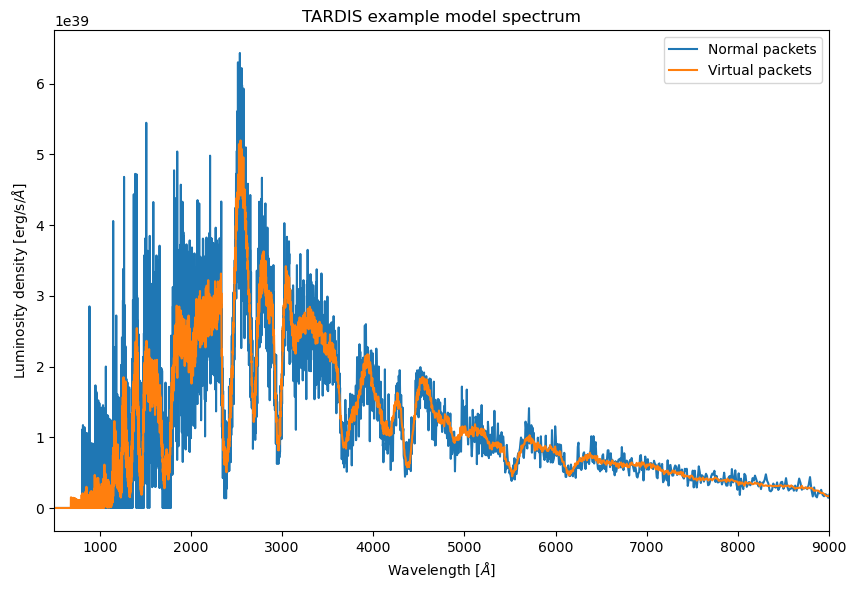

In [7]:
%matplotlib inline
plt.figure(figsize=(10, 6.5))

spectrum.plot(label="Normal packets")
spectrum_virtual.plot(label="Virtual packets")

plt.xlim(500, 9000)
plt.title("TARDIS example model spectrum")
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"Luminosity density [erg/s/$\AA$]")
plt.legend()
plt.show()